# Projekt IAU  
## 3. časť - Strojové učenie
### Vypracovali: Martin Kukučka, Martin Jankuliak
### Číslo datasetu: 80
### Podiel práce: 50/50

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob
import re
import datetime
from datetime import datetime
from numpy.random import seed 
from numpy.random import randn 
from numpy import mean
from numpy import std
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from numpy import exp
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot

from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

import category_encoders as ce

from numpy import percentile

import scipy as sc
from pandas import read_csv


from sklearn.preprocessing import PowerTransformer






from sklearn.metrics import classification_report, confusion_matrix















%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy import stats
from sklearn.model_selection import StratifiedKFold
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
import datetime
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from datetime import datetime,date
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import json
import re
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import dateutil.parser as parser
import statsmodels.api as sm
import sqlite3
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import sklearn
from sklearn.feature_selection import SelectFromModel
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin,BaseEstimator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris

Funkcia, ktorá nahradí chýbajúce hodnoty v stĺpci column modusom (najviac vyskytovaný element). Funkcia využíva SimpleImputer.

In [4]:
def get_mode(data_frame, column):
    data = data_frame[column].values.reshape(-1, 1)
    imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    data_frame[column] = imp.fit_transform(data)
    return data_frame

Funkcia, ktorá nahradí chýbajúce hodnoty v stĺpci column mediánom.

In [5]:
def get_median(data_frame, column):
    median = data_frame[column].median()
    data_frame[column].fillna(median, inplace = True)
    return data_frame

Funkcia, ktorá nahradí chýbajúce hodnoty v stĺpci column priemerom.

In [6]:
def get_mean(data_frame, column):
    mean = data_frame[column].mean()
    data_frame[column].fillna(mean, inplace = True)
    return data_frame

Naplnenie chýbajúcich hodnôt v stĺpci / stĺpcoch modusom.

In [7]:
 def fill_mode(data_frame, columns):
    for col in columns:
        data_frame = get_mode(data_frame, col)
    
    return data_frame

Naplnenie chýbajúcich hodnôt v stĺpci / stĺpcoch mediánom.

In [8]:
 def fill_median(data_frame, columns):
    for col in columns:
        data_frame = get_median(data_frame, col)
        
    return data_frame

Naplnenie chýbajúcich hodnôt v stĺpci / stĺpcoch priemerom.

In [9]:
 def fill_mean(data_frame, columns):
    for col in columns:
        data_frame = get_mean(data_frame, col)
        
    return data_frame

Pomocou tejto funkcie prevádzame adresu na numerickú hodnotu tak, že z danej adresy zistíme ZIP code / PSČ a uložíme ho do pôvodného záznamu

In [10]:
def get_zip(data_frame, column):
    for i in range(len(data_frame[column])):
        zipcode = str(data_frame[column][i])
        data_frame.loc[i, column] = zipcode[len(zipcode) - 5:len(zipcode)]
    data_frame[column] = data_frame[column].astype('int')
    return data_frame

Funkcia ráta vek respondentov v záznamoch. Našou analýzou sme zistili, že záznamy sú robené v rokoch 2018 a 2019. Z každého záznamu vezmeme atribút age a ak je hodnota tohto atribútu záporná alebo trojciferná (uvažujeme ako outliery), tak pomocou atribútu date-of-birth vypočítame nový vek. Ak nový vek zostane naďalej záporný alebo trojciferný, tak jednoducho tieto záznamy vymažeme. 

In [11]:
def calculate_age(data_frame, date_of_birth, age):
    for i in range(len(data_frame[date_of_birth])):
        curr_age = int(data_frame[age][i])
        
        if curr_age < 0 or curr_age > 99:
            year = data_frame[date_of_birth][i]
            year = year[:4]            
            new_age = 2019 - int(year)
            
            if new_age < 0 or new_age > 99:
                data_frame = data_frame.drop(i)
            else:
                data_frame.loc[i, age] = str(new_age)
                
    data_frame = data_frame.reset_index()
    data_frame = data_frame.drop('index', 1)        
    return data_frame

Funkcia, ktorá zjednotí duplikáty.

In [12]:
def unify_rows(data_frame):
    aggregation_functions = {}
    for col in data_frame.columns:
        aggregation_functions[col] = "first" 

    return data_frame.groupby(data_frame['name'], as_index=False).aggregate(aggregation_functions)

Pomocou tejto funkcie sme nahradzovali formáty hodnôt iba jednou hodnotou. Napr. hodnoty v atribúte pregnant (F, FALSE, f) sme nahradili hodnotou f.

In [13]:
def cleanse_some_values(data_frame, column, change_from, change_to):
    for i in range(len(change_from)):
        data_frame.loc[data_frame[column] == change_from[i], column] = change_to

V tejto funkcií sme pre každý atribút, kde sme uznali, že by bolo vhodné, zjednotili dáta. Vyuzili sme pipeline-u.

In [14]:
def unify_values(data_frame):
    unify_ppl = Pipeline([
                    ('1. step',  cleanse_some_values(data_frame, 'pregnant', ["F", "FALSE"], "f")),
                    ('2. step', cleanse_some_values(data_frame, 'pregnant', ["T", "TRUE"], "t")),

                    ('3. step', cleanse_some_values(data_frame, 'marital-status', [" Widowed", " Never-married", " Divorced"], "single")),
                    ('4. step',cleanse_some_values(data_frame, 'marital-status', [" Married-civ-spouse", " Separated", " Married-AF-spouse", " Married-spouse-absent"], "married")),

                    ('5. step', cleanse_some_values(data_frame, 'education', [" 1st-4th", " 5th-6th", " 7th-8th", " 9th", " 10th", " 11th", " 12th"], "Primary school")),
                    ('6. step', cleanse_some_values(data_frame, 'education', [" Bachelors", " Masters", " Doctorate"], "College")),
                    ('7. step', cleanse_some_values(data_frame, 'education', [" Assoc-voc", " HS-grad", " Prof-school", " Assoc-acdm", " Some-college"], "Highschool")),
                    ('8. step', cleanse_some_values(data_frame, 'education', [" Preschool"], "Preschool")),

                    ('9. step', cleanse_some_values(data_frame, 'workclass', [" Private"], "private")),
                    ('10. step', cleanse_some_values(data_frame, 'workclass', [" Self-emp-not-inc", " Self-emp-inc", "self-emp-inc", "self-emp-not-inc"], "self-emp")),
                    ('11. step', cleanse_some_values(data_frame, 'workclass', [" Never-worked", " Without-pay"], "not-working")),
                    ('12. step', cleanse_some_values(data_frame, 'workclass', [" Local-gov", "local-gov", " State-gov", "state-gov", " Federal-gov", "federal-gov"], "government")),
                    ('13. step', cleanse_some_values(data_frame, 'workclass', [" ?", "?"], np.nan))
                    ])
    unify_ppl = unify_ppl.fit(data_frame)
    data_frame = unify_ppl.transform(data_frame)
    return data_frame

Funkcia na zjednotenie formátu dátumov vo formáte YEAR-MONTH-DAY

In [15]:
def change_date_format(data_frame, column):
    for i in range(len(data_frame[column])):
        date_format = str(data_frame[column][i])
        date_format = date_format.replace('/', '-')
        if date_format[2] == '-' and len(date_format) < 10:
            temp_year = int(date_format[:2])
            if(temp_year <= 20):
                if(temp_year < 10):
                    year = '200'+str(temp_year)
                else:
                    year = '20'+str(temp_year)
            else:
                year = '19'+str(temp_year)
            data_frame.loc[i, column] = year+date_format[2:10]
        elif date_format[2] == '-' and len(date_format) == 10:
            day = date_format[:2]
            month = date_format[3:5]
            year = date_format[6:10]
            data_frame.loc[i, column] = year+'-'+month+'-'+day
        else:
            data_frame.loc[i, column] = date_format[:10]
    return data_frame

Funkcia zmaže outliery (v našom zadaní sme sa snažili outliery radšej nahrádzať ako mazať, preto nebolo potrebné túto funkciu použiť).

In [16]:
# def remove_outliers(data_frame, column):
#     a = data_frame[column]
#     lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
#     upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
#     outliers = a[(a > upper) | (a < lower)]
#     data_frame = data_frame.drop(outliers.index)
    
#     data_frame = data_frame.reset_index()
#     data_frame = data_frame.drop('index', 1)
    
#     return data_frame

Ďalšia funkcia na zmazanie outlierov (Interquartile Range Method).

In [17]:
# def remove_outliers_iqr(data_frame, column):
#     seed(1)
#     data = data_frame[column]
#     sns.distplot(data)

#     # calculate interquartile range
#     q25, q75 = percentile(data, 25), percentile(data, 75)
#     iqr = q75 - q25
#     print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr)) 

#     # calculate the outlier cutoff
#     cut_off = iqr * 1.5
#     lower, upper = q25 - cut_off, q75 + cut_off
#     print('cutoff=', cut_off, 'lower=', lower, 'upper=', upper)

#     # identify outliers
#     outliers = data[(data > upper) | (data < lower)]
#     print('Identified outliers: %d' % len(outliers))

#     # remove outliers
#     outliers_removed = [x for x in data if x >= lower and x <= upper] 
#     print('Non-outlier observations: %d' % len(outliers_removed))

#     sns.distplot(outliers_removed)
    
#     data_frame = data_frame.drop(outliers.index)
    
#     data_frame = data_frame.reset_index()
#     data_frame = data_frame.drop('index', 1)

#     return data_frame

Funkcia slúži na zmenu hodnoty "t" atribútu pregnant na "f" pre mužov (" Male" z atribútu sex).

In [18]:
def man_not_pregnant(data_frame, sex, pregnant):
    for i in range(len(data_frame[sex])):
        if(data_frame[sex][i] == " Male") and data_frame[pregnant][i] != "f":
            data_frame.loc[i, pregnant] = "f"
    return data_frame

Funkcia transformácie numerických dát, aby boli dáta lepšie distribuované. Zvolili sme metódu yeo-johnson, pretože pracuje nielen s pozitívnymi ale aj s negatívnymi hodnotami.

In [19]:
def transform_data(data_frame, columns):
    for col in columns:
        data = data_frame[col].values.reshape(-1, 1)
        power = PowerTransformer(method='yeo-johnson', standardize=True) 
        data_frame[col] = power.fit_transform(data)
        
    return data_frame

Funkcia mení kategorické dáta na numerické. Typ udáva akou formou prebieha kódovanie.

In [20]:
def encoding(data_frame, column, typ):
    data = data_frame[column]

    if typ == 0:
        ce_ordinal = ce.OneHotEncoder(cols=[column])
        data_frame[column] = ce_ordinal.fit_transform(data)
        
    elif typ == 1:
        ce_ordinal = ce.OrdinalEncoder(cols=[column])
        data_frame[column] = ce_ordinal.fit_transform(data)
    
    return data_frame

Funkcia mení kategorické dáta atribútu pregnant na numerické 0 - not pregnant, 1 - pregnant

In [21]:
def encode_pregnant(data_frame):
    cleanse_some_values(data_frame, 'pregnant', ["f"], 0)
    cleanse_some_values(data_frame, 'pregnant', ["t"], 1)
    data_frame['pregnant'] = data_frame['pregnant'].astype('int')
    return data_frame

Zakódovanie atribútov obsahujúcich kategorické hodnoty. 

In [22]:
def encode_objects(data_frame):
    data_frame = encoding(data_frame, 'sex', 0)
    data_frame = encoding(data_frame, 'race', 1)
    data_frame = encoding(data_frame, 'marital-status', 1)
    data_frame = encoding(data_frame, 'occupation', 1)
    data_frame = encode_pregnant(data_frame)
    data_frame = encoding(data_frame, 'relationship', 1)
    data_frame = encoding(data_frame, 'education', 1)
    data_frame = encoding(data_frame, 'income', 0)
    data_frame = encoding(data_frame, 'native-country', 1)
    data_frame = encoding(data_frame, 'workclass', 1)
    
    return data_frame

Funkcia na načítanie .csv súborov, ich spojenie podľa atribútov name a address a vyhodenie nepotrebných atribútov

In [23]:
def load_data(typ):
    if(typ == 0):
        df_other = read_csv("data/other_train.csv")
        df_personal = read_csv("data/personal_train.csv")
    elif(typ == 1):
        df_other = read_csv("data/other_valid.csv")
        df_personal = read_csv("data/personal_valid.csv")

    data_frame1 = pd.merge(df_personal, df_other, on=['name', 'address'])

    data_frame = unify_rows(data_frame1)

    data_frame = data_frame.drop('Unnamed: 0_x', 1)
    data_frame = data_frame.drop('Unnamed: 0_y', 1)

    return data_frame

Funkia detailnejšie rozďeluje atribút medical-info na ďalšie atribúty (do viacero stĺpcov), ktoré sa potom pretypujú na typ float.

In [24]:
def split_medical_info(data_frame):
    medical_line = data_frame["medical_info"].str.replace(':', ',').str.replace("'", '').str.replace("{", '').str.replace("}", '')
    medical_elements = medical_line.str.split(",", -1, expand = True)

    diabetes_dataset = {}

    for index in range(0, medical_elements.shape[1]):
        i = medical_elements[0][0]
        if(index % 2 == 0):
            diabetes_dataset[medical_elements[index][0]] = medical_elements[index + 1]

    diabetes_dataset = pd.DataFrame(diabetes_dataset)
    data_frame = pd.concat([data_frame, diabetes_dataset.reindex(data_frame.index)], axis = 1)
    data_frame = data_frame.drop(columns = ['medical_info'])
    
    data_frame['mean_glucose'] = data_frame['mean_glucose'].astype(float)
    data_frame['std_glucose'] = data_frame['std_glucose'].astype(float)
    data_frame['kurtosis_glucose'] = data_frame['kurtosis_glucose'].astype(float)
    data_frame['skewness_glucose'] = data_frame['skewness_glucose'].astype(float)
    data_frame['mean_oxygen'] = data_frame['mean_oxygen'].astype(float)
    data_frame['std_oxygen'] = data_frame['std_oxygen'].astype(float)
    data_frame['kurtosis_oxygen'] = data_frame['kurtosis_oxygen'].astype(float)
    data_frame['skewness_oxygen'] = data_frame['skewness_oxygen'].astype(float)
    
    return data_frame

Funkcia nahradzuje outliery hodnotami z 5% alebo 95% kvartilu. Použili sme Interquartile Range Method.

In [25]:
def replace_outliers(data_frame, columns):
    
    for i in range(len(columns)):
#         sns.distplot(data_frame[columns[i]])

        # calculate interquartile range
        q5, q95 = percentile(data_frame[columns[i]], 5), percentile(data_frame[columns[i]], 95)
        iqr = q95 - q5
#         print('Percentiles: 5th=%.3f, 95th=%.3f, IQR=%.3f' % (q5, q95, iqr)) 

        # calculate the outlier cutoff
        cut_off = iqr * 1.5
        lower, upper = q5 - cut_off, q95 + cut_off
#         print('cutoff=', cut_off, 'lower=', lower + cut_off, 'upper=', upper - cut_off)

        # identify outliers
        outliers = data_frame[columns[i]][(data_frame[columns[i]] > upper) | (data_frame[columns[i]] < lower)]
#         print('Identified outliers: %d' % len(outliers))

        # data without outliers
        outliers_removed = data_frame[columns[i]][(data_frame[columns[i]] <= upper) & (data_frame[columns[i]] >= lower)]
#         print('Non-outlier observations: %d' % len(outliers_removed))


        for j, value in data_frame.iterrows():
                    if value[columns[i]] < lower:
                        data_frame.loc[j, columns[i]] = lower
                    elif value[columns[i]] > upper:
                        data_frame.loc[j, columns[i]] = upper

#         sns.distplot(data_frame[columns[i]])
    
    return data_frame

Kedže niektoré dáta nemôžu byť záporné (jedná sa o štandardnú odchýlku), tak záporné hodnoty tohto atribútu zmeníme na kladné.

In [26]:
def change_to_positive(data_frame, col):
    for i in range(len(data_frame[col])):
        data = data_frame[col][i]
        if data < 0:
            data_frame.loc[i, col] = abs(data)
    return data_frame

Využitie kNN imputácie na doplnenie chýbajúcich hodnôt.

In [27]:
def knn(data_frame, columns):
    # summarize total missing
    print("Missing: " + str(data_frame.isnull().sum().sum()))

#     temp = [col for col in data_frame.columns if data_frame[col].dtypes != 'O']

    temp = columns

    # define imputer
    imputer = KNNImputer()

    # fit on the dataset
    imputer.fit(data_frame[temp])

    # transform the dataset
    data_frame[temp] = imputer.transform(data_frame[temp])
    Xtrans = imputer.transform(data_frame[temp])

    # summarize total missing
    print("Missing: " + str(sum(isnan(Xtrans).flatten())))
    
    return data_frame

Execute funkcia je hlavná funkcia, ktorá spúšťa všetky ostatné.

In [28]:
def execute():
    for i in range(2):
        df_merged = load_data(i)
        df_merged = split_medical_info(df_merged)
        df_merged = unify_values(df_merged)
        df_merged = change_date_format(df_merged,'date_of_birth')
        df_merged = change_to_positive(df_merged, 'std_glucose')

        df_merged = knn(df_merged, ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 
                                'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'])
        df_merged = fill_median(df_merged, ['education-num', 'fnlwgt', 'hours-per-week'])
        df_merged = fill_mode(df_merged, ['class', 'race', 'marital-status', 'occupation', 'pregnant', 'relationship', 
                                      'education', 'income', 'native-country', 'workclass'])
        df_merged = fill_mean(df_merged, ['capital-gain', 'capital-loss'])
        df_merged = man_not_pregnant(df_merged, 'sex', 'pregnant')
        df_merged = get_zip(df_merged,'address')
        df_merged = df_merged.drop('name', 1)
        df_merged = calculate_age(df_merged, 'date_of_birth', 'age')
        df_merged = df_merged.drop('date_of_birth', 1)
        df_merged = encode_objects(df_merged)
        df_merged = replace_outliers(df_merged, ['capital-gain', 'capital-loss', 'skewness_oxygen'])
    # # V analýze sme zistili, že v atribúte capital-loss sa všetky outliere nahradili rovnakou hodnotou, preto tento atribút 
    # # nemá žiadnu výpovednú hodnotu a je vhodné ho zmazať (zakomentovať, ak atribút mazať nechceme).
        df_merged = df_merged.drop('capital-loss', 1)
        df_merged = transform_data(df_merged, ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 
                                'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'])
    # # Uloženie upravenej dátovej sady do .csv súboru
        if i == 0:
            df_merged.to_csv(r'data\train.csv')
        elif i == 1:
            df_merged.to_csv(r'data\valid.csv')

Spustenie

In [29]:
execute()

Missing: 895
Missing: 0


c:\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Missing: 305
Missing: 0


c:\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Potrebovali sme upraviť kód tak, aby sme pre trénovací aj validačný dataset vykonali rovnaké operácie. Pôvodná funkcia execute() sa vykonávala iba raz a do jedného .csv súboru sa uložil trénovací aj validačný dataset. Teraz sme túto funkciu upravili spoločne s funkciou load_data(), do ktorej sme pridali parameter, ktorý udáva, o ktorý dataset sa jedná. Funkcia execute sa teraz vykonáva dvakrát. Najprv sa spracuje trénovací dataset, uloží sa a rovnaký proces sa vykoná aj pre validačný dataset.

Načítanie predspracovaných dát.

In [30]:
df_train = read_csv("data/train.csv")
df_valid = read_csv("data/valid.csv")

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3931 non-null   int64  
 1   address           3931 non-null   int64  
 2   age               3931 non-null   int64  
 3   sex               3931 non-null   int64  
 4   race              3931 non-null   int64  
 5   marital-status    3931 non-null   int64  
 6   occupation        3931 non-null   int64  
 7   pregnant          3931 non-null   int64  
 8   education-num     3931 non-null   float64
 9   relationship      3931 non-null   int64  
 10  capital-gain      3931 non-null   float64
 11  education         3931 non-null   int64  
 12  fnlwgt            3931 non-null   float64
 13  class             3931 non-null   float64
 14  income            3931 non-null   int64  
 15  native-country    3931 non-null   int64  
 16  hours-per-week    3931 non-null   float64


In [32]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1311 non-null   int64  
 1   address           1311 non-null   int64  
 2   age               1311 non-null   int64  
 3   sex               1311 non-null   int64  
 4   race              1311 non-null   int64  
 5   marital-status    1311 non-null   int64  
 6   occupation        1311 non-null   int64  
 7   pregnant          1311 non-null   int64  
 8   education-num     1311 non-null   float64
 9   relationship      1311 non-null   int64  
 10  capital-gain      1311 non-null   float64
 11  education         1311 non-null   int64  
 12  fnlwgt            1311 non-null   float64
 13  class             1311 non-null   float64
 14  income            1311 non-null   int64  
 15  native-country    1311 non-null   int64  
 16  hours-per-week    1311 non-null   float64


In [33]:
def split_df(data_frame, column):
    X = data_frame.drop(columns=[column])
    y = data_frame[column]
    return X,y

In [34]:
X_train,y_train = split_df(df_train, "class")

In [35]:
X_test,y_test = split_df(df_valid, "class")

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3931 non-null   int64  
 1   address           3931 non-null   int64  
 2   age               3931 non-null   int64  
 3   sex               3931 non-null   int64  
 4   race              3931 non-null   int64  
 5   marital-status    3931 non-null   int64  
 6   occupation        3931 non-null   int64  
 7   pregnant          3931 non-null   int64  
 8   education-num     3931 non-null   float64
 9   relationship      3931 non-null   int64  
 10  capital-gain      3931 non-null   float64
 11  education         3931 non-null   int64  
 12  fnlwgt            3931 non-null   float64
 13  income            3931 non-null   int64  
 14  native-country    3931 non-null   int64  
 15  hours-per-week    3931 non-null   float64
 16  workclass         3931 non-null   int64  


# 2

In [37]:
target_names = ['0 - negatívny', '1 - pozitívny']

#### mean_glucose

<AxesSubplot:xlabel='class', ylabel='mean_glucose'>

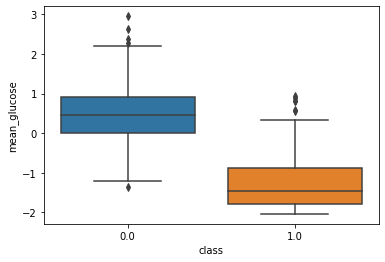

In [38]:
sns.boxplot(x = 'class', y = 'mean_glucose', data = df_valid)

In [39]:
predictions = []

for index,row in X_test.iterrows():
    if row.mean_glucose < -0.77:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.930     0.974     0.951       965
1 - pozitívny      0.917     0.795     0.851       346

     accuracy                          0.927      1311
    macro avg      0.923     0.884     0.901      1311
 weighted avg      0.926     0.927     0.925      1311



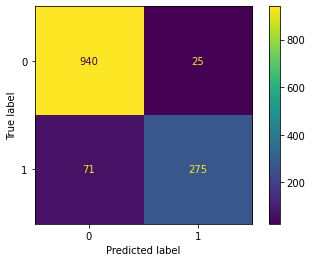

In [40]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### skewness_glucose

<AxesSubplot:xlabel='class', ylabel='skewness_glucose'>

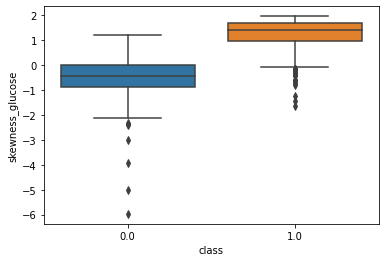

In [41]:
sns.boxplot(x = 'class', y = 'skewness_glucose', data = df_valid)

In [42]:
predictions = []

for index,row in X_test.iterrows():
    if row.skewness_glucose > 0.88:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.927     0.987     0.956       965
1 - pozitívny      0.954     0.783     0.860       346

     accuracy                          0.933      1311
    macro avg      0.941     0.885     0.908      1311
 weighted avg      0.934     0.933     0.931      1311



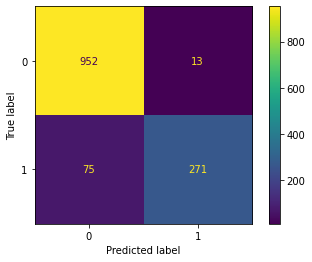

In [43]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### kurtosis_glucose

<AxesSubplot:xlabel='class', ylabel='kurtosis_glucose'>

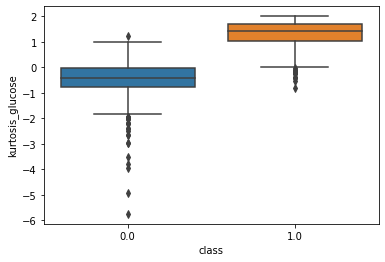

In [44]:
sns.boxplot(x = 'class', y = 'kurtosis_glucose', data = df_valid)

In [45]:
predictions = []

for index,row in X_test.iterrows():
    if row.kurtosis_glucose > 0.65:
        predictions.append(1)
    else:
        predictions.append(0)

print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.958     0.981     0.969       965
1 - pozitívny      0.944     0.879     0.910       346

     accuracy                          0.954      1311
    macro avg      0.951     0.930     0.940      1311
 weighted avg      0.954     0.954     0.954      1311



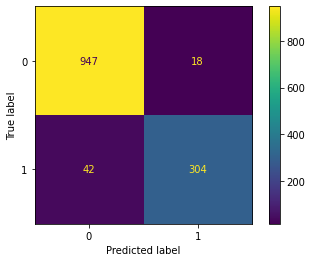

In [46]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### std_glucose, skewness_glucose

<AxesSubplot:xlabel='std_glucose', ylabel='skewness_glucose'>

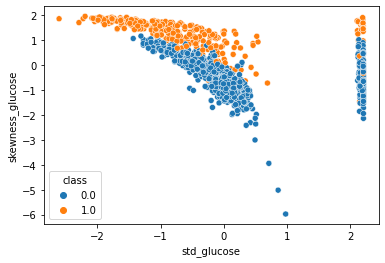

In [47]:
sns.scatterplot(x = 'std_glucose', y = 'skewness_glucose',hue="class", data = df_valid)

In [48]:
predictions = []

for index,row in X_test.iterrows():
    if row.std_glucose < 0.2 and row.skewness_glucose > 1.0:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.879     0.993     0.932       965
1 - pozitívny      0.968     0.618     0.755       346

     accuracy                          0.894      1311
    macro avg      0.924     0.806     0.844      1311
 weighted avg      0.903     0.894     0.886      1311



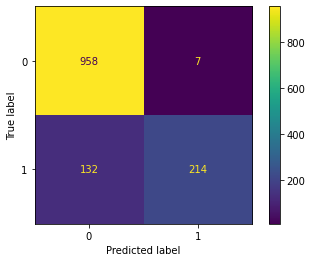

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### mean_glucose, skewness_glucose, kurtosis_glucose

In [50]:
predictions = []

for index,row in X_test.iterrows():
    if row.mean_glucose < -0.77 and row.skewness_glucose > 0.88 and row.kurtosis_glucose > 0.8:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.921     0.997     0.957       965
1 - pozitívny      0.989     0.760     0.859       346

     accuracy                          0.934      1311
    macro avg      0.955     0.879     0.908      1311
 weighted avg      0.939     0.934     0.931      1311



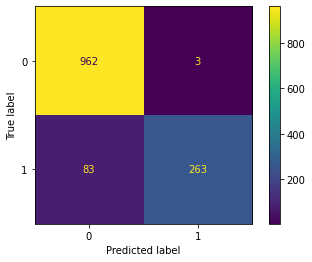

In [51]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### mean_oxygen

<AxesSubplot:xlabel='class', ylabel='mean_oxygen'>

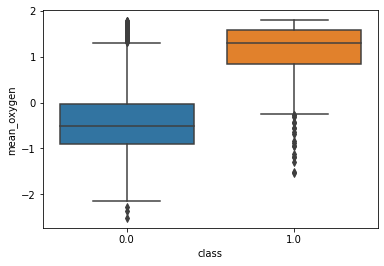

In [52]:
sns.boxplot(x = 'class', y = 'mean_oxygen', data = df_valid)

In [53]:
predictions = []

for index,row in X_test.iterrows():
    if row.mean_oxygen > 0.7:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.928     0.905     0.916       965
1 - pozitívny      0.751     0.803     0.777       346

     accuracy                          0.878      1311
    macro avg      0.840     0.854     0.846      1311
 weighted avg      0.881     0.878     0.879      1311



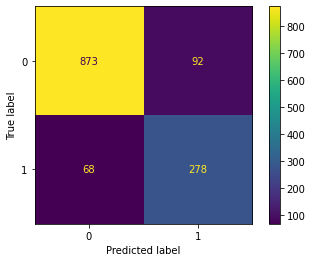

In [54]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### skewness_oxygen

<AxesSubplot:xlabel='class', ylabel='skewness_oxygen'>

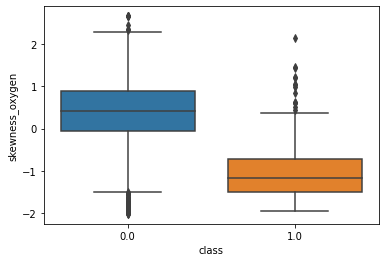

In [55]:
sns.boxplot(x = 'class', y = 'skewness_oxygen', data = df_valid)

In [56]:
predictions = []

for index,row in X_test.iterrows():
    if row.skewness_oxygen < -0.61:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.925     0.898     0.912       965
1 - pozitívny      0.738     0.798     0.767       346

     accuracy                          0.872      1311
    macro avg      0.832     0.848     0.839      1311
 weighted avg      0.876     0.872     0.873      1311



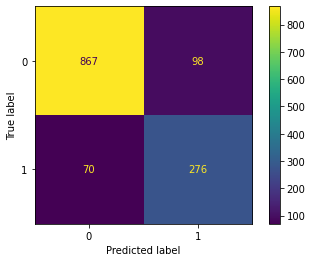

In [57]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### std_oxygen

<AxesSubplot:xlabel='class', ylabel='std_oxygen'>

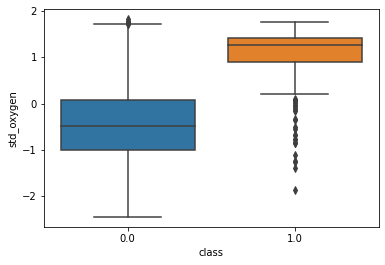

In [58]:
sns.boxplot(x = 'class', y = 'std_oxygen', data = df_valid)

In [59]:
predictions = []

for index,row in X_test.iterrows():
    if row.std_oxygen > 0.81:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.923     0.905     0.914       965
1 - pozitívny      0.748     0.789     0.768       346

     accuracy                          0.874      1311
    macro avg      0.835     0.847     0.841      1311
 weighted avg      0.877     0.874     0.875      1311



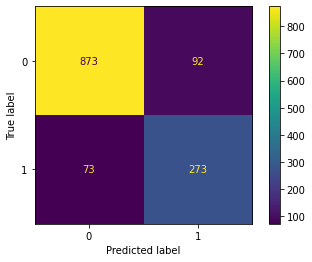

In [60]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### skewness_oxygen, kurtosis_oxygen

<AxesSubplot:xlabel='skewness_oxygen', ylabel='kurtosis_oxygen'>

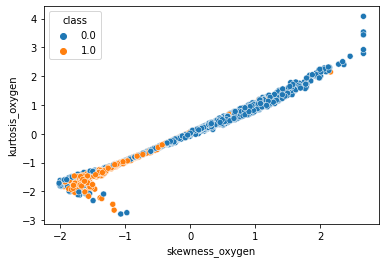

In [61]:
sns.scatterplot(x = 'skewness_oxygen', y = 'kurtosis_oxygen',hue="class", data = df_valid)

In [62]:
predictions = []

for index,row in X_test.iterrows():
    if row.skewness_oxygen < -0.61 and row.kurtosis_oxygen < -0.61:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.924     0.903     0.913       965
1 - pozitívny      0.745     0.792     0.768       346

     accuracy                          0.873      1311
    macro avg      0.834     0.847     0.840      1311
 weighted avg      0.876     0.873     0.875      1311



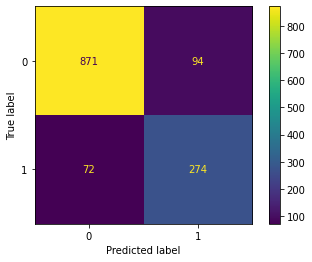

In [63]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### std_oxygen, mean_oxygen

<AxesSubplot:xlabel='std_oxygen', ylabel='mean_oxygen'>

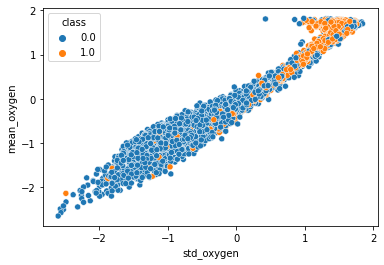

In [64]:
sns.scatterplot(x = 'std_oxygen', y = 'mean_oxygen',hue="class", data = df_train )

In [65]:
predictions = []

for index,row in X_test.iterrows():
    if row.std_oxygen > 0.81 and row.mean_oxygen > 0.7:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.921     0.908     0.914       965
1 - pozitívny      0.753     0.783     0.768       346

     accuracy                          0.875      1311
    macro avg      0.837     0.846     0.841      1311
 weighted avg      0.877     0.875     0.876      1311



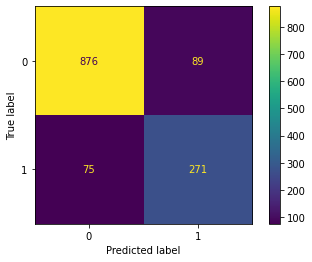

In [66]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

#### mean_oxygen, skewness_oxygen, kurtosis_oxygen

In [67]:
predictions = []

for index,row in X_test.iterrows():
    if row.mean_oxygen > 0.7 and row.skewness_oxygen < -0.61 and row.kurtosis_oxygen < -0.61:
        predictions.append(1)
    else:
        predictions.append(0)
        
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.924     0.907     0.915       965
1 - pozitívny      0.753     0.792     0.772       346

     accuracy                          0.876      1311
    macro avg      0.838     0.849     0.844      1311
 weighted avg      0.879     0.876     0.877      1311



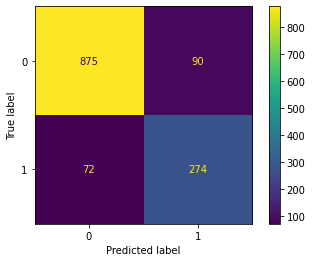

In [68]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

# 3

In [69]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.969     0.954     0.962       965
1 - pozitívny      0.878     0.916     0.897       346

     accuracy                          0.944      1311
    macro avg      0.924     0.935     0.929      1311
 weighted avg      0.945     0.944     0.945      1311



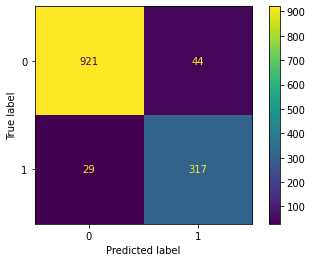

In [70]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

[Text(222.71435917264105, 211.7178947368421, 'X[19] <= 0.499\ngini = 0.38\nsamples = 3931\nvalue = [2928, 1003]'),
 Text(155.22742324814985, 200.2736842105263, 'X[2] <= 77.5\ngini = 0.086\nsamples = 3025\nvalue = [2889, 136]'),
 Text(122.77104966466234, 188.82947368421054, 'X[19] <= -0.12\ngini = 0.08\nsamples = 3013\nvalue = [2888, 125]'),
 Text(65.2914199814986, 177.38526315789474, 'X[6] <= 12.5\ngini = 0.021\nsamples = 2102\nvalue = [2080, 22]'),
 Text(34.26202590194264, 165.94105263157894, 'X[19] <= -0.426\ngini = 0.017\nsamples = 2048\nvalue = [2030, 18]'),
 Text(12.388529139685476, 154.49684210526317, 'X[20] <= -2.952\ngini = 0.005\nsamples = 1305\nvalue = [1302, 3]'),
 Text(4.95541165587419, 143.05263157894737, 'X[20] <= -3.3\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(2.477705827937095, 131.60842105263157, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(7.4331174838112855, 131.60842105263157, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(19.82164662349676, 143.052

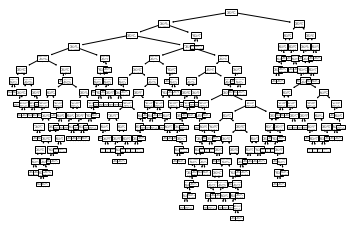

In [71]:
tree.plot_tree(clf) 

In [72]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/matto/miniconda3/Library/bin/graphviz'

graph = Source(export_graphviz(clf, 
                               out_file=None,
                               feature_names=X_test.columns,
                               class_names=['0', '1'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))
from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:60% !important;height:60% !important;}</style>"
HTML(style)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [73]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions, digits = 3, target_names=target_names))

               precision    recall  f1-score   support

0 - negatívny      0.972     0.980     0.976       965
1 - pozitívny      0.944     0.922     0.933       346

     accuracy                          0.965      1311
    macro avg      0.958     0.951     0.955      1311
 weighted avg      0.965     0.965     0.965      1311



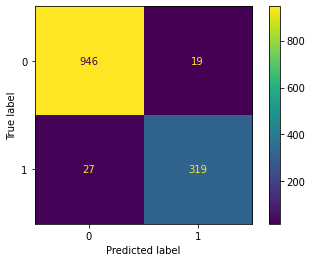

In [74]:
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions)).plot()

## Hyperparametre

In [108]:
estimator = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_leaf': [1, 3] }
scoring = ['accuracy', 
           'precision_micro']

clf = GridSearchCV(estimator=estimator, 
                   param_grid=parameters,
                   cv=10,
                   scoring=scoring,
                   refit='accuracy')
search = clf.fit(X_train, y_train)


print(search.best_estimator_)
print(search.best_score_)
print(search.best_params_)
print(search.n_splits_)

# list(ParameterGrid(parameters))
# search.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=0)
0.9600631611578254
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3, 'splitter': 'best'}
10


In [91]:
estimator = RandomForestClassifier()
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'n_estimators': [50, 100],
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [1, 3] }
scoring = ['accuracy', 
#            'f1_macro',
            'precision_micro']

clf = GridSearchCV(estimator=estimator, 
                   param_grid=parameters,
                   cv=10,
                   scoring=scoring,
                   refit='accuracy')
search = clf.fit(X_train, y_train)


print(search.best_estimator_)
print(search.best_score_)
print(search.best_params_)
print(search.n_splits_)

# list(ParameterGrid(parameters))

RandomForestClassifier(max_depth=9, n_estimators=50)
0.962605752961083
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 50}
10


In [93]:
estimator = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_leaf': [1, 3] }
scoring = ['accuracy', 
           'precision_micro']

clf = RandomizedSearchCV(estimator=estimator, 
                   param_distributions=parameters,
                   cv=10,
                   scoring=scoring,
                   refit='accuracy')
search = clf.fit(X_train, y_train)


print(search.best_estimator_)
print(search.best_score_)
print(search.best_params_)
print(search.n_splits_)

# list(ParameterGrid(parameters))
search.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, random_state=0)
0.9562457214450861
{'splitter': 'best', 'min_samples_leaf': 3, 'max_depth': 7, 'criterion': 'gini'}
10


DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, random_state=0)

In [95]:
estimator = RandomForestClassifier()
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [50, 100],
              'min_samples_leaf': [1, 3] }
scoring = ['accuracy', 
           'precision_micro']

clf = RandomizedSearchCV(estimator=estimator, 
                   param_distributions=parameters,
                   cv=10,
                   scoring=scoring,
                   refit='accuracy')
search = clf.fit(X_train, y_train)


print(search.best_estimator_)
print(search.best_score_)
print(search.best_params_)
print(search.n_splits_)

# list(ParameterGrid(parameters))
search.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=50)
0.96311530463311
{'n_estimators': 50, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'gini'}
10


RandomForestClassifier(max_depth=9, n_estimators=50)